In [1]:
import pandas as pd
import utils
import numpy as np
import warnings
from tqdm import tqdm
from copairs.map import mean_average_precision, multilabel
import logging
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
all_profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

retrieval_label = "disease_association"
multi_label_col = "Metadata_disease_list"
annotation_col = "Metadata_disease_involvement"


batch_size = 20000
null_size = 20000
fdr = 0.05

pos_sameby = [f"{multi_label_col}"]
pos_diffby = []
neg_sameby = []
neg_diffby = [f"{multi_label_col}"]

disease_blocklist = [
     "Disease variant", 
     "Cancer-related genes",
     "FDA approved drug targets",
     "Intellectual disability"
]

Read protein class annotations

In [3]:
orf_annotation_df = (
    pd.read_csv(
        "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep="\t"
    )[["Metadata_JCP2022", f"{annotation_col}", "Metadata_pert_type", "Metadata_NCBI_Gene_ID"]]
    .dropna()
    .assign(col=lambda x: list(x[f"{annotation_col}"].str.split("|")))
    .rename(columns={"col": f"{multi_label_col}"})
    .explode(f"{multi_label_col}")
    .query(f"{multi_label_col} not in @disease_blocklist")
    .drop(columns=f"{annotation_col}")
    .groupby(["Metadata_JCP2022", "Metadata_pert_type", "Metadata_NCBI_Gene_ID"])[f"{multi_label_col}"]
    .apply(lambda x: np.unique(x))
    .reset_index()
)

In [4]:
crispr_controls_df = pd.DataFrame(
    {
        "Metadata_JCP2022": ["JCP2022_805264", "JCP2022_800001", "JCP2022_800002"],
        "Metadata_pert_type": ["poscon", "negcon", "negcon"],
    },
    index=[0, 1, 2],
)

crispr_annotation_df = (
    pd.read_csv(
        "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep="\t"
    )[["Metadata_JCP2022", f"{annotation_col}", "Metadata_NCBI_Gene_ID"]]
    .merge(crispr_controls_df, on="Metadata_JCP2022", how="left")
    .fillna(value={"Metadata_pert_type": "trt"})
    .dropna()
    .assign(col=lambda x: list(x[f"{annotation_col}"].str.split("|")))
    .rename(columns={"col": f"{multi_label_col}"})
    .explode(f"{multi_label_col}")
    .query(f"{multi_label_col} not in @disease_blocklist")
    .drop(columns=f"{annotation_col}")
    .groupby(["Metadata_JCP2022", "Metadata_pert_type", "Metadata_NCBI_Gene_ID"])[f"{multi_label_col}"]
    .apply(lambda x: np.unique(x))
    .reset_index()
)

In [5]:
similarity_df = pd.DataFrame()

for modality in all_profiles:
    print(f"Modality: {modality}")
    parquet_file_name = f"profiles_{all_profiles[modality]}.parquet"
    phenotypic_activity_file_name = (
        f"phenotypic-activity-{all_profiles[modality]}.csv.gz"
    )

    df = pd.read_parquet(f"../profiles/{parquet_file_name}")
    phenotypic_activity_df = pd.read_csv(
        f"../03.retrieve-annotations/output/{phenotypic_activity_file_name}"
    ).query("below_corrected_p==True")
    df = df.merge(phenotypic_activity_df, on="Metadata_JCP2022", how="inner")

    if modality == "ORF":
        df = df.merge(
            orf_annotation_df,
            on="Metadata_JCP2022",
            how="inner",
        )
    elif modality == "CRISPR":
        df = df.merge(
            crispr_annotation_df,
            on="Metadata_JCP2022",
            how="inner",
        )

    consensus_df = utils.consensus(df, "Metadata_NCBI_Gene_ID")

    metadata_df = utils.get_metadata(consensus_df)
    feature_df = utils.get_featuredata(consensus_df)
    feature_values = feature_df.values

    df = utils.compute_pairwise_cosine_similarities(
        metadata_df,
        feature_values,
        pos_sameby,
        pos_diffby,
        neg_sameby,
        neg_diffby,
        batch_size=batch_size,
        multilabel_col=multi_label_col,
    ).assign(Modality=modality)

    similarity_df = pd.concat([similarity_df, df], ignore_index=True)

Modality: ORF


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Modality: CRISPR


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

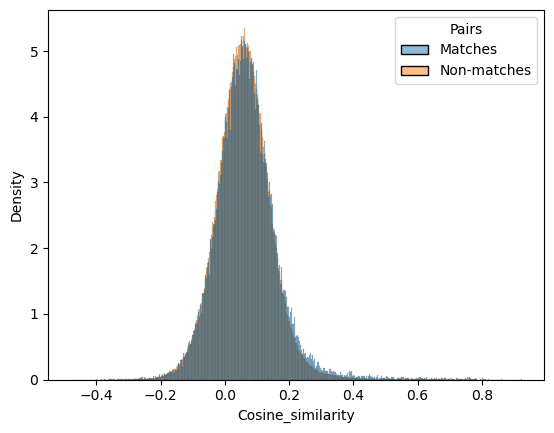

In [6]:
sns.histplot(
    data=similarity_df.query("Modality == 'ORF'"),
    x="Cosine_similarity",
    hue="Pairs",
    common_norm=False,
    stat="density",
)

plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-orfs.png", dpi=300)
plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-orfs.svg", dpi=300)

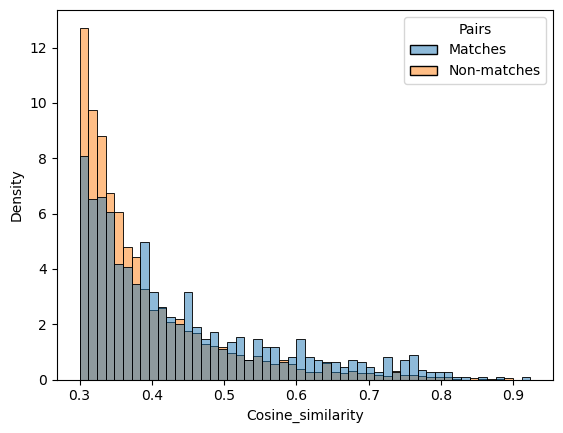

In [7]:
sns.histplot(
    data=similarity_df.query("Modality == 'ORF'").query("Cosine_similarity > 0.3"),
    x="Cosine_similarity",
    hue="Pairs",
    common_norm=False,
    stat="density",
)

plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-orfs-high-similarity.png", dpi=300)
plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-orfs-high-similarity.svg", dpi=300)

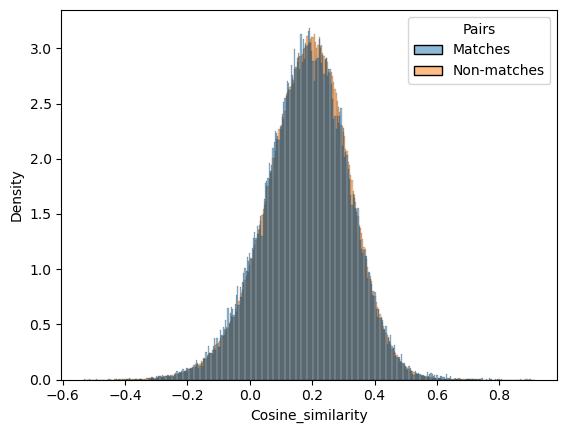

In [8]:
sns.histplot(
    data=similarity_df.query("Modality == 'CRISPR'"),
    x="Cosine_similarity",
    hue="Pairs",
    common_norm=False,
    stat="density",
)

plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-crisprs.png", dpi=300)
plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-crisprs.svg", dpi=300)

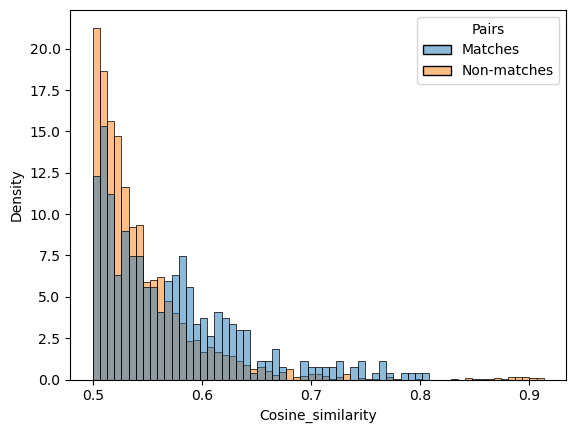

In [9]:
sns.histplot(
    data=similarity_df.query("Modality == 'CRISPR'").query("Cosine_similarity > 0.5"),
    x="Cosine_similarity",
    hue="Pairs",
    common_norm=False,
    stat="density",
)

plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-crisprs-high-similarity.png", dpi=300)
plt.savefig(f"figures/{retrieval_label}-similarity-histogram-all-crisprs-high-similarity.svg", dpi=300)

In [10]:
similarity_df.query("Modality == 'ORF'").query("Cosine_similarity > 0.4").to_csv(f"output/{retrieval_label}-high-similarity-orf.csv.gz", index=False)
similarity_df.query("Modality == 'CRISPR'").query("Cosine_similarity > 0.6").to_csv(f"output/{retrieval_label}-high-similarity-crispr.csv.gz", index=False)